<img src="static/img/co2.jpg.jpg" width="850" height="300">

## 1. Import des packages

In [1]:
# pip install pandas
# !pip install sodapy

In [2]:
import pandas as pd

## 2. Import du dataset

In [3]:
url = 'https://raw.githubusercontent.com/data-IA-2022/CO2_Maud_Tarik/main/data/2016_Building_Energy_Benchmarking.csv'

#Read the CSV file into a DataFrame
df = pd.read_csv(url, encoding="utf8")

In [4]:
from sodapy import Socrata

### Remove rows where ComplianceStatus == 'Missing Data'


In [5]:
7939# Filter the DataFrame to keep only data with Compliant in ComplianceStatus
df = df[df["ComplianceStatus"] == 'Compliant']

In [6]:
# Convert kBtu to kWh in the Electricity column
df["Electricity(kWh)"] = df["Electricity(kBtu)"] * 0.29307107
# Convert kBtu to kWh in the SteamUse column
df['SteamUse(kWh)'] = df['SteamUse(kBtu)'] * 0.29307107
# Convert kBtu to kWh in the SteamUse column
df['NaturalGas(kWh)'] = df['NaturalGas(kBtu)'] * 0.29307107
# Convert kBtu to kWh in the SteamUse column
df['SiteEnergyUse(kWh)'] = df['SiteEnergyUse(kBtu)'] * 0.29307107
# Convert sqrt feet in m²
df['PropertyGFABuilding(s)'] = df['PropertyGFABuilding(s)'] * 0.092903

In [7]:
# Convert the SiteEnergyUse column to the desired format
df["SiteEnergyUse(kWh)"] = df["SiteEnergyUse(kWh)"].apply(lambda x: "{:.2f}".format(x))
# Convert the Electricity(kWh) column to the desired format
df["Electricity(kWh)"] = df["Electricity(kWh)"].apply(lambda x: "{:.2f}".format(x))
# Convert the SteamUse(kWh) column to the desired format
df["SteamUse(kWh)"] = df["SteamUse(kWh)"].apply(lambda x: "{:.2f}".format(x))
# Convert the NaturalGas(kWh) column to the desired format
df["NaturalGas(kWh)"] = df["NaturalGas(kWh)"].apply(lambda x: "{:.2f}".format(x))
# Convert the PropertyGFABuilding(s) column to the desired format
df["PropertyGFABuilding(s)"] = df["PropertyGFABuilding(s)"].apply(lambda x: "{:.2f}".format(x))

In [8]:
# Convert the SiteEnergyUse column to float format
df["SiteEnergyUse(kWh)"] = df["SiteEnergyUse(kWh)"].astype(float)
# Convert the Electricity(kWh) column to float format
df["Electricity(kWh)"] = df["Electricity(kWh)"].astype(float)
# Convert the SteamUse(kWh) column to float format
df["SteamUse(kWh)"] = df["SteamUse(kWh)"].astype(float)
# Convert the NaturalGas(kWh) column to float format
df["NaturalGas(kWh)"] = df["NaturalGas(kWh)"].astype(float)
# Convert the PropertyGFABuilding(s) column to float format
df["PropertyGFABuilding(s)"] = df["PropertyGFABuilding(s)"].astype(float)

In [9]:
df = df[['DataYear', 'BuildingType', 'PrimaryPropertyType','PropertyName', 'City', 'Latitude',
        'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
        'SteamUse(kWh)', 'Electricity(kWh)', 'NaturalGas(kWh)',  'TotalGHGEmissions', 'SiteEnergyUse(kWh)']]

In [10]:
import numpy as np

# Define the offset value
offset = 1.0

# Apply the offset logarithm transformation using numpy
df[['log_totalghgemissions', 'log_siteenergyusekwh']] = df[['TotalGHGEmissions', 'SiteEnergyUse(kWh)']].apply(lambda x: np.log(x + offset))

In [11]:
cols = ['SteamUse(kWh)', 'Electricity(kWh)', 'NaturalGas(kWh)']
for col in cols:
    #print(df[col].head())
    df['is_using_'+col] = df[col].apply(lambda x: 0 if x == 0 else 1)

## Import

In [12]:
'''!pip install xgboost
!pip install lightgbm
!pip install scikit-learn'''

'!pip install xgboost\n!pip install lightgbm\n!pip install scikit-learn'

In [38]:
#pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

#modèles
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#validation croisée, gridsearch et métriques d'erreur
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

import pickle


## Pipeline

In [14]:
df.dropna(subset=['log_totalghgemissions'], inplace=True)


In [15]:
X = df.drop(['DataYear', 'PropertyName', 'City',  'Latitude', 'Longitude', 'ListOfAllPropertyUseTypes', 'SteamUse(kWh)',
       'Electricity(kWh)', 'NaturalGas(kWh)', 'TotalGHGEmissions',
       'SiteEnergyUse(kWh)', 'log_totalghgemissions', 'log_siteenergyusekwh'
            #,'BuildingType', 'PrimaryPropertyType'
            ], axis=1)
y = df[['log_totalghgemissions', 'log_siteenergyusekwh']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
#variables catégorielles à transformer avec OneHotEncoder
column_cat_onehot = ['BuildingType', 'PrimaryPropertyType'
]
transfo_cat_onehot = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
column_numeric = ['YearBuilt', 'NumberofFloors',
       'PropertyGFABuilding(s)']
transfo_numeric = Pipeline(steps=[
    ('scaling', StandardScaler())
])

In [18]:
column_bool = ['is_using_SteamUse(kWh)',
       'is_using_Electricity(kWh)', 'is_using_NaturalGas(kWh)']
transfo_bool = FunctionTransformer(validate=False)

/tmp/ipykernel_6709/2313527159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['target1', 'target2']] = y
/tmp/ipykernel_6709/2313527159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['target1', 'target2']] = y


<AxesSubplot: >

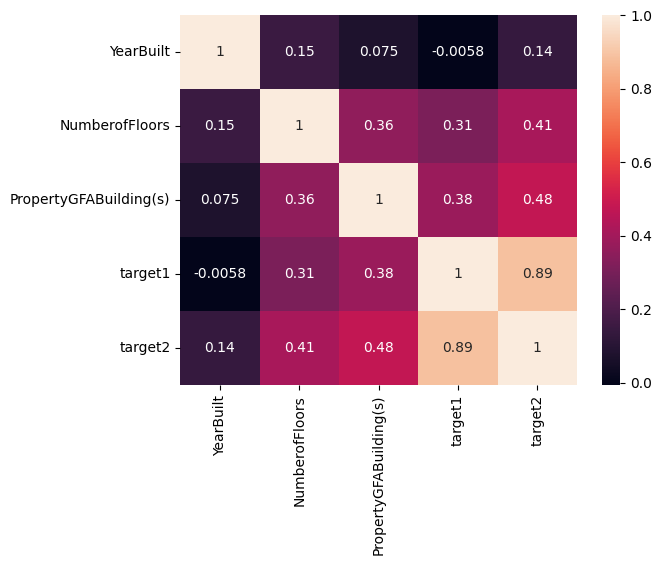

In [41]:
'''#matrice de corrélation avant scaler
import seaborn as sns

df_test = X[['YearBuilt', 'NumberofFloors',
       'PropertyGFABuilding(s)']]

df_test[['target1', 'target2']] = y

sns.heatmap(df_test.corr(), annot=True)'''


/tmp/ipykernel_6709/303378710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['target1', 'target2']] = y
/tmp/ipykernel_6709/303378710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['target1', 'target2']] = y


<AxesSubplot: >

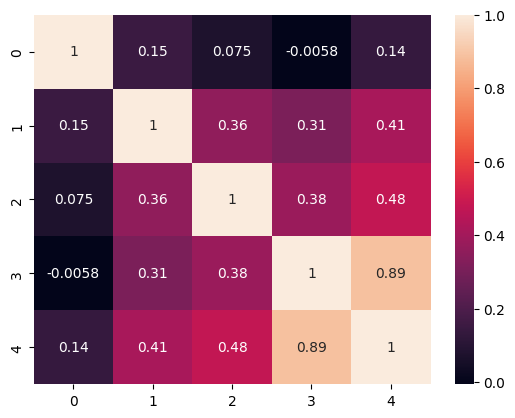

In [42]:
'''#matrice de corrélation après scaler
scaler = RobustScaler()

df_test = X[['YearBuilt', 'NumberofFloors',
       'PropertyGFABuilding(s)']]

df_test[['target1', 'target2']] = y

df_test = scaler.fit_transform(df_test)

df_test = pd.DataFrame(df_test)

sns.heatmap(df_test.corr(), annot=True)'''


In [21]:
# Création du préparateur de données
preparation = ColumnTransformer(transformers=[
    ('data_numeric', transfo_numeric, column_numeric),
    ('data_cat_onehot', transfo_cat_onehot, column_cat_onehot),
    ('data_bool', transfo_bool, column_bool)
])

In [22]:
'''# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_cat_onehot', transfo_cat_onehot , column_cat_onehot)
    ])'''

"# Class ColumnTransformer : apply alls steps on the whole dataset\npreparation = ColumnTransformer(\n    transformers=[\n        ('data_cat_onehot', transfo_cat_onehot , column_cat_onehot)\n    ])"

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
'''# Appliquer le ColumnTransformer sur l'ensemble des features
X_transformed = preparation.fit_transform(X_untransformed)

# Concaténer les features transformées avec les features non transformées
X_final = np.concatenate((X_transformed, X_untransformed), axis=1)'''

"# Appliquer le ColumnTransformer sur l'ensemble des features\nX_transformed = preparation.fit_transform(X_untransformed)\n\n# Concaténer les features transformées avec les features non transformées\nX_final = np.concatenate((X_transformed, X_untransformed), axis=1)"

## Models

In [25]:
models = [
    xgb.XGBRegressor(),
    lgb.LGBMRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor()
]


In [26]:
parameters_xgb = {
    'model__estimator__n_estimators': [100, 200, 500],
    'model__estimator__max_depth': [3, 5, 7],
    'model__estimator__learning_rate': [0.1, 0.01, 0.001]
}

parameters_lgb = {
    'model__estimator__n_estimators': [100, 200, 500],
    'model__estimator__max_depth': [3, 5, 7],
    'model__estimator__learning_rate': [0.1, 0.01, 0.001]
}

parameters_gbt = {
    'model__estimator__n_estimators': [100, 200, 500],
    'model__estimator__max_depth': [3, 5, 7],
    'model__estimator__learning_rate': [0.1, 0.01, 0.001]
}

parameters_rf = {
    'model__estimator__n_estimators': [100, 200, 500],
    'model__estimator__max_depth': [3, 5, 7]
}



In [27]:
models_opti = []
parameters = {}

In [28]:
#boucle sur chaque modèle de ma liste, pour lesquels je vais tester les différents paramètres définis plus tôt et enregistrer la meilleure version de chaque modèle dans une liste
for n in models:
    
    multi_reg = MultiOutputRegressor(n)
    
    model = Pipeline(steps=[('preparation', preparation),
                    ('model',multi_reg)])

    if isinstance(n, xgb.XGBRegressor):
        parameters = parameters_xgb
    elif isinstance(n, RandomForestRegressor):
        parameters = parameters_rf
    elif isinstance(n, lgb.LGBMRegressor):
        parameters = parameters_lgb
    elif isinstance(n, GradientBoostingRegressor):
        parameters = parameters_gbt

#enregistrement de la meilleure version de chaque modèe
    gscv = GridSearchCV(model, parameters, scoring='r2', cv=5)
    gscv.fit(X_train, y_train)
    models_opti.append(gscv)
    
    #print(n, "Résultat", gscv.cv_results_['mean_test_score'])
    print(n, gscv.best_score_, gscv.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 0.7942026016405036 {'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 100}
LGBMRegressor() 0.7790256209270399 {'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 5, 'model__estimato

In [37]:
best_score = float('-inf')
best_model = None

for model_opti in models_opti:
    if model_opti.best_score_ > best_score:
        best_score = model_opti.best_score_
        best_model = model_opti.best_estimator_

best_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_numeric',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)']),
                                                 ('data_cat_onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType']),
                                                 ('data_bool',
                                                  FunctionTransformer(),
                                                  ['is_...
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=5,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)))])

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

# test the model on the test data and display the scores
y_pred = model_tm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 0.3967163449948135
R-squared Score: 0.7787738807261693


## Prédiction

In [31]:
X.columns

Index(['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'is_using_SteamUse(kWh)',
       'is_using_Electricity(kWh)', 'is_using_NaturalGas(kWh)'],
      dtype='object')

In [32]:
new_data={
        'BuildingType': 'NonResidential',
        'PrimaryPropertyType': 'Retail Store',
        'YearBuilt': '2023',
        'NumberofFloors': '3',
        'PropertyGFABuilding(s)': '78170',
        'is_using_SteamUse(kWh)': '0',
        'is_using_Electricity(kWh)': '1',
        'is_using_NaturalGas(kWh)': '1'
}

df_pred = pd.DataFrame(new_data, index=[0])
df_pred

,BuildingType,PrimaryPropertyType,YearBuilt,NumberofFloors,PropertyGFABuilding(s),is_using_SteamUse(kWh),is_using_Electricity(kWh),is_using_NaturalGas(kWh)
0,NonResidential,Retail Store,2023,3,78170,0,1,1


In [33]:
pred_satisfaction = model_tm.predict(df_pred)

In [34]:
pred_satisfaction_original = np.exp(pred_satisfaction)

ghgemissions = round(pred_satisfaction_original[0][0], 2)

energyuse = round(pred_satisfaction_original[0][1], 2)

print("Total GHG Emissions:", ghgemissions, "équivalent tonne CO2")
print("Site Energy Use:", energyuse, "kWh")

Total GHG Emissions: 486.37 équivalent tonne CO2
Site Energy Use: 7882344.17 kWh


## Save model

In [35]:
'''with open('model.pickle', 'wb') as f:
    pickle.dump(model_tm, f)

f.close()'''


"with open('model.pickle', 'wb') as f:\n    pickle.dump(model_tm, f)\n\nf.close()"

In [36]:
'''with open('model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

f.close()'''


"with open('model.pickle', 'rb') as f:\n    loaded_model = pickle.load(f)\n\nf.close()"